# EQUITY AMERICAN OPTION - QL COMPARISON

Valuation and Risk of American-style options on equity compared with example at
http://gouthamanbalaraman.com/blog/american-option-pricing-quantlib-python.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.finutils import *
from financepy.market.curves.FinDiscountCurveFlat import *
from financepy.products.equity import *

####################################################################
# FINANCEPY BETA Version 0.180 - This build:  23 Sep 2020 at 00:02 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#    For bug reports and comments - allmypythonprojects@gmail.com  #
####################################################################



# Define the Call and Put Options

In [3]:
valueDate = FinDate(8, 5, 2015)

In [4]:
expiryDate = FinDate(15, 1, 2016)

In [5]:
strikePrice = 130

Create the call Option

In [6]:
amCallOption = FinEquityAmericanOption(expiryDate, strikePrice, FinOptionTypes.AMERICAN_CALL)

In [7]:
print(amCallOption)

OBJECT TYPE: FinEquityAmericanOption
EXPIRY DATE: FRI 15 JAN 2016
STRIKE PRICE: 130
OPTION TYPE: FinOptionTypes.AMERICAN_CALL
NUMBER: 1.0


We can also define an American option with a European payoff - this way we will use the same CRR tree for the pricing.

In [8]:
euCallOption = FinEquityAmericanOption(expiryDate, strikePrice, FinOptionTypes.EUROPEAN_CALL)

We can also define an actual vanilla call option which will be priced using Black Scholes.

In [9]:
callOption = FinEquityVanillaOption(expiryDate, strikePrice, FinOptionTypes.EUROPEAN_CALL)

Now we can explore the pricing of all three to check for consistency and tree convergence.

## Valuation

In [10]:
stockPrice = 127.62
volatility = 0.20
interestRate = 0.001
dividendYield = 0.0163

In [11]:
discountCurve = FinDiscountCurveFlat(valueDate, interestRate,
                                     FinFrequencyTypes.CONTINUOUS, FinDayCountTypes.ACT_365F)

We now define the model. This is Black-Scholes. We can also specify the number of steps to use on the tree,

In [12]:
numStepsPerYear = 400

In [13]:
model = FinEquityModelBlackScholes(volatility, numStepsPerYear)

In [14]:
amCallOption.value(valueDate, stockPrice, discountCurve, dividendYield, model)

6.839055125613104

Compare it to European using same tree

In [15]:
euCallOption.value(valueDate, stockPrice, discountCurve, dividendYield, model)

6.751036144304809

This is lower as we would expect due to the lack of early exercise. Let's check this against the Black Scholes model analytical form.

In [16]:
callOption.value(valueDate, stockPrice, discountCurve, dividendYield, model)

6.749271812460599

The price is close to the 6.74927 found by QL - see http://gouthamanbalaraman.com/blog/european-option-binomial-tree-quantlib-python.html. Differences with QL could be due to differences in time calculations. It is also different from the Tree value but that is a tree convergence issue. Let's see how good convergence is.

## Tree Convergence

In [17]:
numStepsPerYear = range(5, 200, 1)

In [18]:
amTreeValue = []
euTreeValue = []
euAnalValue = []
volatility = 0.20

for numSteps in numStepsPerYear:
    model = FinEquityModelBlackScholes(volatility, numSteps)
    v_am = amCallOption.value(valueDate, stockPrice, discountCurve, dividendYield, model)
    v_eu = euCallOption.value(valueDate, stockPrice, discountCurve, dividendYield, model)
    v_bs = callOption.value(valueDate, stockPrice, discountCurve, dividendYield, model)
    
    amTreeValue.append(v_am)
    euTreeValue.append(v_eu)
    euAnalValue.append(v_bs)

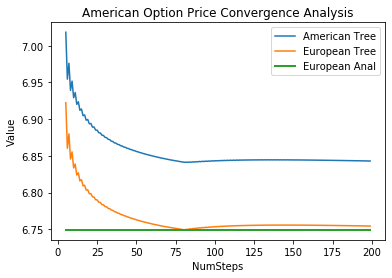

In [19]:
plt.title("American Option Price Convergence Analysis")
plt.plot(numStepsPerYear, amTreeValue, label="American Tree")
plt.plot(numStepsPerYear, euTreeValue, label="European Tree")
plt.plot(numStepsPerYear, euAnalValue, label="European Anal", lw =2)
plt.xlabel("NumSteps")
plt.ylabel("Value")
plt.legend();

Agreement with QL is very good and tree convergence appears much better - probably assisted by fact that I average even and odd numbers of steps internally.

Copyright (c) 2020 Dominic O'Kane